In [1]:
import imp
import os
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import glob
import cv2
import PIL
import matplotlib.pyplot as plt
from pyMLaux.functions import evaluate_classification_result, plot_history

# Kaggle Rome dataset base line: custom cnn model
Check for GPU

In [2]:
tf.get_logger().setLevel('ERROR')

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Basic constants

In [3]:
data_dir = "./../data/kaggle-rome-weather-dataset-resized"
batch_size = 16
number_images = 50
image_height = 224
image_width = 224
nr_color_channels = 3
seed = 2023

Create ImageDataGenerator for data augmentation of training data

In [4]:
datagen = keras.preprocessing.image.ImageDataGenerator(rescale=(1. / 255),
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   rotation_range=10,
                                   horizontal_flip=True,
                                   fill_mode='constant',
                                   validation_split= 0.2,
                                   cval=0)

Get training data

In [5]:
img_train = datagen.flow_from_directory(data_dir, target_size=(image_width,image_height), 
                                                    batch_size=batch_size,  subset='training', seed=seed,
                                                    class_mode='categorical')
img_train

Found 200 images belonging to 5 classes.


Get test data

In [6]:
img_test = datagen.flow_from_directory(data_dir, target_size=(image_width,image_height), 
                                                    batch_size=batch_size,  subset='validation', seed=seed,
                                                    class_mode='categorical')
img_test

Found 50 images belonging to 5 classes.


Build model

model architecture based on: https://www.kaggle.com/code/tejaswi2003/20bd1a6637-weather-classification-cnn 

In [7]:
model = tf.keras.models.Sequential()
model.add(keras.layers.Conv2D(32,activation="relu",kernel_size=3,input_shape=(image_width, image_height, 3)))
model.add(keras.layers.MaxPooling2D((2,2),padding='same'))
model.add(keras.layers.Conv2D(64,activation="relu",kernel_size=3))
model.add(keras.layers.MaxPooling2D((2,2),padding='same'))
model.add(keras.layers.Conv2D(128,activation="relu",kernel_size=3))
model.add(keras.layers.MaxPooling2D((2,2),padding='same'))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(100,activation="relu"))
model.add(keras.layers.Dense(5,activation="softmax"))


Create model checkpoints

In [8]:
filepath = "./" + 'models/rome_custom/rome_custom_{epoch:02d}-{val_accuracy:.4f}.hdf5'
check_point = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,
                                                save_best_only=True, mode='max')

In [9]:
callbacks_list = [check_point]

In [10]:
model.compile(loss='categorical_crossentropy',
                  optimizer=keras.optimizers.RMSprop(learning_rate=2e-5),
                  metrics=['accuracy'])

In [11]:
history = model.fit(img_train,
                    steps_per_epoch=(len(img_train.filenames) // batch_size), 
                    epochs=25,
                    validation_data=img_test, 
                    validation_steps=(len(img_test.filenames) // batch_size),
                    callbacks=callbacks_list)

Epoch 1/25
12/12 [==============================] - 14s 313ms/step - loss: 1.6041 - accuracy: 0.2344 - val_loss: 1.5487 - val_accuracy: 0.3750

Epoch 00001: val_accuracy improved from -inf to 0.37500, saving model to ./models/rome_custom\rome_custom_01-0.3750.hdf5
Epoch 2/25
12/12 [==============================] - 3s 292ms/step - loss: 1.5463 - accuracy: 0.3478 - val_loss: 1.5147 - val_accuracy: 0.3958

Epoch 00002: val_accuracy improved from 0.37500 to 0.39583, saving model to ./models/rome_custom\rome_custom_02-0.3958.hdf5
Epoch 3/25
12/12 [==============================] - 4s 322ms/step - loss: 1.4929 - accuracy: 0.3804 - val_loss: 1.4695 - val_accuracy: 0.4583

Epoch 00003: val_accuracy improved from 0.39583 to 0.45833, saving model to ./models/rome_custom\rome_custom_03-0.4583.hdf5
Epoch 4/25
12/12 [==============================] - 4s 298ms/step - loss: 1.4471 - accuracy: 0.4728 - val_loss: 1.4283 - val_accuracy: 0.4792

Epoch 00004: val_accuracy improved from 0.45833 to 0.47917

Evaluate model

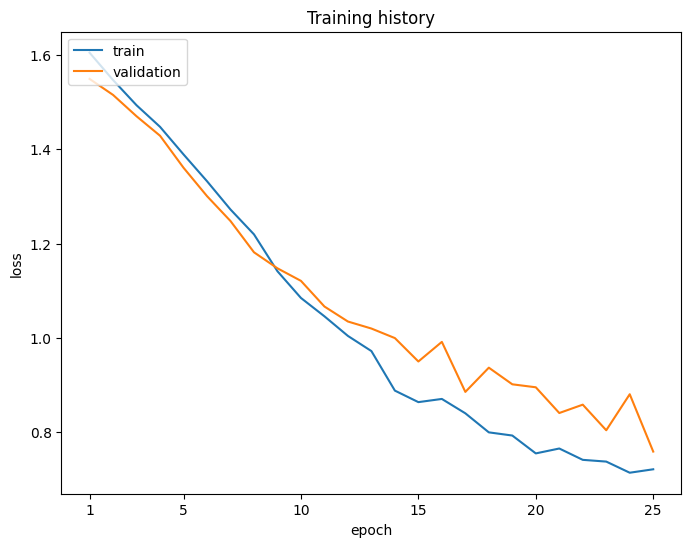

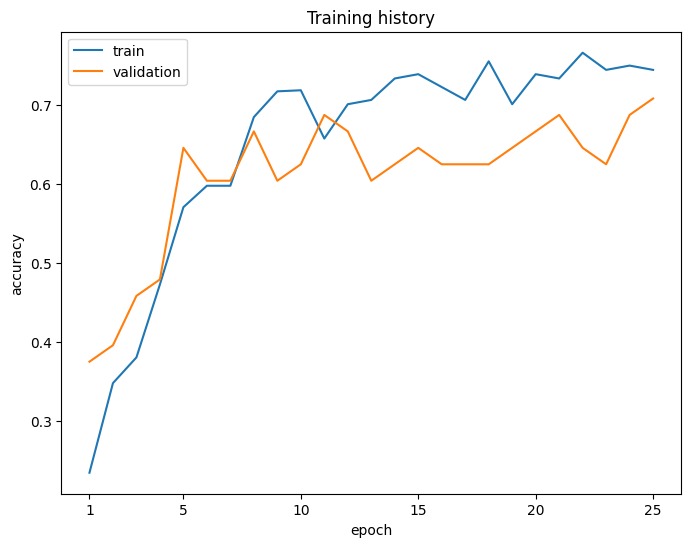

In [12]:
plot_history(history)

Load best model

In [14]:
model = keras.models.load_model("./models/rome_custom/rome_custom_25-0.7083.hdf5")
pred = model.predict(img_test, steps=len(img_test.filenames))

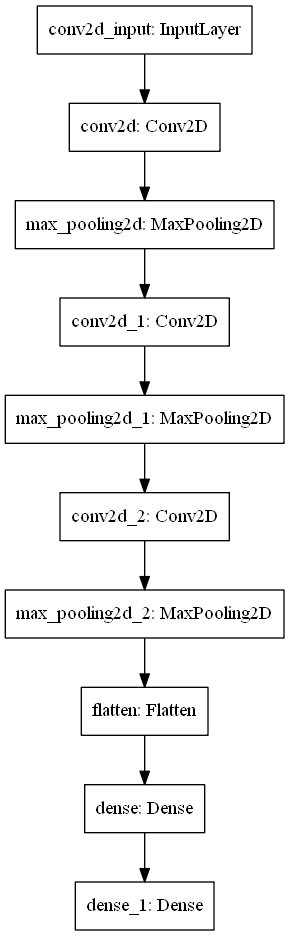

In [15]:
keras.utils.plot_model(model)

In [16]:
evaluate_classification_result(img_test.classes, pred,classes=["foggy","cloudy","sunny","snowy","rainy"])

[[2 4 0 4 0]
 [3 0 4 2 1]
 [4 2 0 2 2]
 [2 2 0 3 3]
 [3 3 0 2 2]]


Class foggy:
    Sensitivity (TPR):  20.000% (2 of 10)
    Specificity (TNR):  70.000% (28 of 40)
    Precision:          14.286% (2 of 14)
    Neg. pred. value:   77.778% (28 of 36)
Class cloudy:
    Sensitivity (TPR):   0.000% (0 of 10)
    Specificity (TNR):  72.500% (29 of 40)
    Precision:           0.000% (0 of 11)
    Neg. pred. value:   74.359% (29 of 39)
Class sunny:
    Sensitivity (TPR):   0.000% (0 of 10)
    Specificity (TNR):  90.000% (36 of 40)
    Precision:           0.000% (0 of 4)
    Neg. pred. value:   78.261% (36 of 46)
Class snowy:
    Sensitivity (TPR):  30.000% (3 of 10)
    Specificity (TNR):  75.000% (30 of 40)
    Precision:          23.077% (3 of 13)
    Neg. pred. value:   81.081% (30 of 37)
Class rainy:
    Sensitivity (TPR):  20.000% (2 of 10)
    Specificity (TNR):  85.000% (34 of 40)
    Precision:          25.000% (2 of 8)
    Neg. pred. value:   80.952% (34 of 42)

Overall accuracy:

array([[2, 4, 0, 4, 0],
       [3, 0, 4, 2, 1],
       [4, 2, 0, 2, 2],
       [2, 2, 0, 3, 3],
       [3, 3, 0, 2, 2]], dtype=int64)